# 0. Imports

In [1]:
import numpy as np
import pandas as pd

import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from datasets import Dataset as Dataset_HF
from torch.utils.data import Dataset

import torch
import gc
import re

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load Dataset

In [5]:
adhd_df = pd.read_csv('/kaggle/input/adhdnot-adhd-dataset/ADHD.csv')
adhd_df.head()

,Unnamed: 0,text,content,wording,prompt_id,prompt_question,prompt_title,prompt_text,student_id
0,0,"Hey, did you knwo? At the top of the socal lad...",0.863521,0.560241,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ded6a14b4c27
1,1,"Hey, did yOU kow? Guess what? So the social go...",0.237703,0.500000,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,95c8b1d33694
2,2,"HEy, did you know? Here's a story: The Differe...",0.378200,0.542762,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,55918828da86
3,3,"Guess what? Hey, did you know? The pharaohs, t...",0.789650,0.859773,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,e70311747892
4,4,"iN ancienct Egpt, tEy could raed and wrtie. Th...",0.495394,0.500000,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,875c0d066910


In [6]:
not_adhd_df = pd.read_csv('/kaggle/input/adhdnot-adhd-dataset/Not_ADHD.csv')
not_adhd_df.head()

,Unnamed: 0,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,0,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ded6a14b4c27,In the structure of the ancient Egyptian gover...,0.425078,0.519454
1,1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,95c8b1d33694,"In the ancient Egyptian system of government, ...",0.483478,0.328477
2,2,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,55918828da86,The a try tire of ancient Egypt is they belove...,0.274036,0.320513
3,3,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,e70311747892,The pharoah is at the top and is seen as the s...,0.648103,0.771420
4,4,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,875c0d066910,Different social classes were involved in this...,0.522206,0.355555


# 2. Data Prepocessing

First, we need to remove some special symbols in the text because it has no semantic meaning.

In [7]:
adhd_df['text'] = adhd_df["text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
not_adhd_df['text'] = test["text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

# 3. Set Configuration

In [8]:
class CFG:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_length=512
    hidden_dropout_prob=0.005
    attention_probs_dropout_prob=0.005
    model_name = "distilroberta-base"
    tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/distilroberta-base')
    model = AutoModelForSequenceClassification.from_pretrained('/kaggle/input/distilroberta-base',num_labels=2,problem_type="regression").to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model_config = AutoConfig.from_pretrained('/kaggle/input/distilroberta-base')
model_config.update({
        "hidden_dropout_prob": CFG.hidden_dropout_prob,
        "attention_probs_dropout_prob": CFG.attention_probs_dropout_prob,
        "num_labels": 2,
        "problem_type": "regression",
    })

## Data Collector

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=CFG.tokenizer)

## Evaluation Function

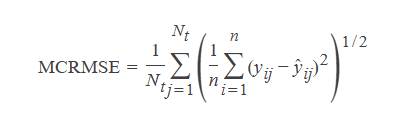

In [11]:
def caculate_mcrmse(eval_pred):
    predictions, labels = eval_pred
    squared_errors = np.square(predictions - labels)
    mean_squared_errors = np.mean(squared_errors, axis=0)
    rmse = np.sqrt(mean_squared_errors)

    mcrmse_value = np.mean(rmse)
    content_rmse = rmse[0]
    wording_rmse = rmse[1]
    
    return {
        "mcrmse": mcrmse_value,
        "content_rmse": content_rmse,
        "wording_rmse": wording_rmse
    }

In [13]:
df_train, df_valid = train_test_split(adhd_df, test_size=0.2, random_state=42, stratify=adhd_df['prompt_id'])

# 4. Dataset for different targets

In [16]:
train_content = df_train[["prompt_question", "text", "content", "wording"]]
valid_content = df_valid[["prompt_question", "text", "content", "wording"]]

df_test = adhd_df[["prompt_question","text"]]

**Now we need to transform the dataframe to dataset.**

In [17]:
train_dataset_content = Dataset_HF.from_pandas(train_content, preserve_index=False) 
valid_dataset_content = Dataset_HF.from_pandas(valid_content, preserve_index=False) 
test_dataset = Dataset_HF.from_pandas(df_test, preserve_index=False) 

# 5. Tokenizer

**We need to tokenize the text before put it into a model. We are gonna distinguish between training set and test set. If it is a training set, the tokenizer will return a dictionary including input id, attention mask, and labels.**

**If it is a training set, only the input id and attention mask will be returned.**

In [18]:
def tokenize_function(examples,dataset='train'):
    if dataset == 'train':
        labels = [examples["content"], examples["wording"]]
        tokenized = CFG.tokenizer(examples["text"],
                                  examples["prompt_question"],
                                  padding=False,
                                  truncation=True,
                                  max_length=CFG.max_length)
        return {**tokenized,"labels": labels}
        
    elif dataset == 'test':
        tokenized = CFG.tokenizer(examples["text"],
                                  examples["prompt_question"],
                                  padding=False,
                                  truncation=True,
                                  max_length=CFG.max_length)
        
        return tokenized

In [19]:
train_tokenized_datasets_content = train_dataset_content.map(lambda example: tokenize_function(example, dataset='train'), batched=False)
valid_tokenized_datasets_content = valid_dataset_content.map(lambda example: tokenize_function(example, dataset='train'), batched=False)
test_tokenized_datasets_content = test_dataset.map(lambda example: tokenize_function(example,dataset='test'),batched=False)

  0%|          | 0/160 [00:00<?, ?ex/s]

  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ex/s]

In [20]:
gc.collect()

19191

# 6. Training a model ADHD

In [21]:
training_args = TrainingArguments(
    output_dir="output",             
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=4,    
    learning_rate=1.5e-5,            
    lr_scheduler_type="linear",      
    warmup_ratio=0.01,               
    num_train_epochs=15,              
    save_strategy="epoch",           
    logging_strategy="epoch",        
    evaluation_strategy="epoch",    
    load_best_model_at_end=True,     
    metric_for_best_model="mcrmse",  
    greater_is_better=False,         
    fp16=False,                      
    report_to='none',                
    save_total_limit=1               
)

trainer = Trainer(
    model=CFG.model,
    train_dataset=train_tokenized_datasets_content,
    eval_dataset=valid_tokenized_datasets_content,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=caculate_mcrmse,
    tokenizer=CFG.tokenizer
)
trainer.train()

trainer.save_model("best_model")

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Mcrmse,Content Rmse,Wording Rmse
1,0.227300,0.021781,0.143050,0.179352,0.106747
2,0.039000,0.013306,0.112730,0.137175,0.088286
3,0.026000,0.019947,0.134229,0.178160,0.090298
4,0.027300,0.016273,0.127560,0.126439,0.128680
5,0.021300,0.013393,0.114280,0.132516,0.096044
6,0.019400,0.012326,0.109368,0.128456,0.090280
7,0.018400,0.010416,0.100360,0.118890,0.081830
8,0.017800,0.010126,0.098267,0.119946,0.076587
9,0.016800,0.014575,0.120726,0.120708,0.120744
10,0.015600,0.011482,0.105600,0.123769,0.087431


In [27]:
# Evaluate on the evaluation dataset
eval_metrics = trainer.evaluate()
eval_metrics

{'eval_loss': 0.009840426035225391,
 'eval_mcrmse': 0.09733566641807556,
 'eval_content_rmse': 0.11647187918424606,
 'eval_wording_rmse': 0.07819944620132446,
 'eval_runtime': 0.2561,
 'eval_samples_per_second': 156.183,
 'eval_steps_per_second': 39.046,
 'epoch': 15.0}

# 7. Prediction

In [22]:
predictions = trainer.predict(test_tokenized_datasets_content)
predictions

PredictionOutput(predictions=array([[0.8258373 , 0.6033035 ],
       [0.42655456, 0.5829246 ],
       [0.3998333 , 0.50809574],
       [0.8141424 , 0.6702635 ],
       [0.52297604, 0.5126585 ],
       [0.74266315, 0.6263867 ],
       [0.40138176, 0.48999536],
       [0.37944508, 0.47491515],
       [0.5097633 , 0.55433905],
       [0.42259926, 0.509009  ],
       [0.3842362 , 0.50960064],
       [0.85744685, 0.6798063 ],
       [0.5834292 , 0.5617824 ],
       [0.6008162 , 0.6004557 ],
       [0.5497267 , 0.54493326],
       [0.35405287, 0.49257284],
       [0.86037344, 0.66030484],
       [0.43175596, 0.5196575 ],
       [0.78405446, 0.5926821 ],
       [0.5035019 , 0.5161082 ],
       [0.4327974 , 0.5572057 ],
       [0.72700936, 0.5431757 ],
       [0.5314757 , 0.5259275 ],
       [0.395965  , 0.507059  ],
       [0.36926976, 0.49610978],
       [0.8332657 , 0.70857614],
       [0.77611035, 0.5951239 ],
       [0.4254981 , 0.5337691 ],
       [0.2817569 , 0.4877927 ],
       [0.3516

In [23]:
content_list = predictions.predictions[:, 0].tolist()
wording_list = predictions.predictions[:, 1].tolist()

# Train Not_adhd Model

In [28]:
df_train, df_valid = train_test_split(not_adhd_df, test_size=0.2, random_state=42, stratify=not_adhd_df['prompt_id'])

In [29]:
train_content = df_train[["prompt_question", "text", "content", "wording"]]
valid_content = df_valid[["prompt_question", "text", "content", "wording"]]

df_test = not_adhd_df[["prompt_question","text"]]

In [30]:
train_dataset_content = Dataset_HF.from_pandas(train_content, preserve_index=False) 
valid_dataset_content = Dataset_HF.from_pandas(valid_content, preserve_index=False) 
test_dataset = Dataset_HF.from_pandas(df_test, preserve_index=False) 

In [31]:
def tokenize_function(examples,dataset='train'):
    if dataset == 'train':
        labels = [examples["content"], examples["wording"]]
        tokenized = CFG.tokenizer(examples["text"],
                                  examples["prompt_question"],
                                  padding=False,
                                  truncation=True,
                                  max_length=CFG.max_length)
        return {**tokenized,"labels": labels}
        
    elif dataset == 'test':
        tokenized = CFG.tokenizer(examples["text"],
                                  examples["prompt_question"],
                                  padding=False,
                                  truncation=True,
                                  max_length=CFG.max_length)
        
        return tokenized

In [32]:
train_tokenized_datasets_content = train_dataset_content.map(lambda example: tokenize_function(example, dataset='train'), batched=False)
valid_tokenized_datasets_content = valid_dataset_content.map(lambda example: tokenize_function(example, dataset='train'), batched=False)
test_tokenized_datasets_content = test_dataset.map(lambda example: tokenize_function(example,dataset='test'),batched=False)

  0%|          | 0/160 [00:00<?, ?ex/s]

  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ex/s]

In [33]:
gc.collect()

575

In [34]:
training_args = TrainingArguments(
    output_dir="output",             
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=4,    
    learning_rate=1.5e-5,            
    lr_scheduler_type="linear",      
    warmup_ratio=0.01,               
    num_train_epochs=15,              
    save_strategy="epoch",           
    logging_strategy="epoch",        
    evaluation_strategy="epoch",    
    load_best_model_at_end=True,     
    metric_for_best_model="mcrmse",  
    greater_is_better=False,         
    fp16=False,                      
    report_to='none',                
    save_total_limit=1               
)

trainer = Trainer(
    model=CFG.model,
    train_dataset=train_tokenized_datasets_content,
    eval_dataset=valid_tokenized_datasets_content,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=caculate_mcrmse,
    tokenizer=CFG.tokenizer
)
trainer.train()

trainer.save_model("best_model")

Epoch,Training Loss,Validation Loss,Mcrmse,Content Rmse,Wording Rmse
1,0.027900,0.025222,0.157073,0.133625,0.180520
2,0.026800,0.024864,0.156783,0.139957,0.173609
3,0.023800,0.031818,0.177702,0.162220,0.193185
4,0.022000,0.028879,0.167954,0.142054,0.193854
5,0.023000,0.024735,0.156229,0.138134,0.174323
6,0.018500,0.019546,0.137551,0.112529,0.162573
7,0.015300,0.023813,0.152646,0.130011,0.175281
8,0.016000,0.021326,0.144913,0.126836,0.162989
9,0.014500,0.019923,0.139632,0.118995,0.160269
10,0.012800,0.021056,0.144509,0.131344,0.157675


In [35]:
# Evaluate on the evaluation dataset
eval_metrics = trainer.evaluate()
eval_metrics

{'eval_loss': 0.019546348601579666,
 'eval_mcrmse': 0.13755087554454803,
 'eval_content_rmse': 0.11252882331609726,
 'eval_wording_rmse': 0.1625729352235794,
 'eval_runtime': 0.1984,
 'eval_samples_per_second': 201.618,
 'eval_steps_per_second': 50.405,
 'epoch': 15.0}

In [36]:
predictions = trainer.predict(test_tokenized_datasets_content)
predictions

PredictionOutput(predictions=array([[0.43226004, 0.4315618 ],
       [0.542861  , 0.43413386],
       [0.33142856, 0.3428762 ],
       [0.6771538 , 0.6102366 ],
       [0.585866  , 0.45964393],
       [0.91530657, 0.6393415 ],
       [0.7799133 , 0.4958163 ],
       [0.24551217, 0.29815078],
       [0.65410227, 0.51633143],
       [0.44146326, 0.3485523 ],
       [0.3126849 , 0.3185013 ],
       [0.24687384, 0.30016527],
       [0.4803463 , 0.57024574],
       [0.64050144, 0.5392771 ],
       [0.648003  , 0.5679201 ],
       [0.80404323, 0.6443508 ],
       [0.755205  , 0.46475935],
       [0.4847301 , 0.37262017],
       [0.65167063, 0.5311907 ],
       [0.4504611 , 0.37793112],
       [0.31617916, 0.34274283],
       [0.67559004, 0.54005295],
       [0.9044731 , 0.6658863 ],
       [0.5423657 , 0.4651054 ],
       [0.45262668, 0.3568003 ],
       [0.6809032 , 0.5324651 ],
       [0.38537782, 0.31128693],
       [0.7056734 , 0.50338465],
       [0.29647744, 0.31074914],
       [0.6332

In [37]:
content_list = predictions.predictions[:, 0].tolist()
wording_list = predictions.predictions[:, 1].tolist()